# 1. APP Loading

## 1.0. Open Database

In [ ]:
import requests
import pandas as pd
import sqlite3
import tqdm
import requests as rq
from bs4 import BeautifulSoup
from io import BytesIO
import re
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "AppleGothic"
import myAPI_keys as Key
import db.init_db as init_db


init_db.init_entire_database()
print("Database initilized! load data from API and insert into database...")


conn = sqlite3.connect("db/StockManageAPP.sqlite")

cur = conn.cursor()

## 1.1. Update [StockInfo] Table

### 1.1.1. Defince Function : Get_Stock_Price 
- 한국증권거래소 API에 종목코드를 파라미터로 이용해, 종목명과 종가 가져옴.

In [ ]:
def Get_Stock_Info():
    endpoint = "http://apis.data.go.kr/1160100/service/GetStockSecuritiesInfoService/getStockPriceInfo"
    url = f"{endpoint}?pageNo={1}&resultType=json&numOfRows={3000}&serviceKey={Key.STOCK_INFO_ENCODED_KEY}"
    response = requests.get(url).json().get("response").get("body").get("items")
    return response

### 1.1.2. [StockInfo Table(df)] 초기 형태 제작
- 금융결제원 API로 불러온 정보를 마지막 검색일자인 정보만 남김.
- 이후 StockInfo의 형태로 df를 제작

In [ ]:
_ans = Get_Stock_Info()
df = pd.DataFrame(_ans.get("item"))[["srtnCd", "itmsNm", "mrktCtg", "clpr", "basDt"]]
last_date = df["basDt"].max()
df = df[df["basDt"] == last_date]
########################################################################
df = pd.DataFrame(df)[["srtnCd", "itmsNm", "mrktCtg", "clpr"]]
df = df.rename(
    columns={
        "srtnCd": "StockCode",
        "itmsNm": "StockName",
        "mrktCtg": "Category",
        "clpr": "Price",
    }
)
df = df.drop(df[df["Category"] == "KONEX"].index)

In [ ]:
df

### 1.1.2. load category table (in memory)
- http://data.krx.co.kr/contents/MDC/MDI/mdiLoader/index.cmd?menuId=MDC0201020502
- KRX에서 업종정보 포함한 종합 정보 csv file 다운 후, 메모리에 불러옴
- 해당 사이트의 API를 이용하기 위해선, 사업자등록번호가 필요하기 때문에 불가피하게 csv file을 다운받아서 사용함.

In [ ]:
# Load the two CSV files with 'euc-kr' encoding
df1 = pd.read_csv("db/doc/data_2239_20231121.csv", encoding="euc-kr")
df2 = pd.read_csv("db/doc/data_2303_20231121.csv", encoding="euc-kr")

# Concatenate the two DataFrames
df3 = pd.concat([df1, df2])

# If you want to reset the index
krx_sector = df3.reset_index(drop=True)

In [ ]:
krx_sector

### 1.1.3. Add Stock{Name, Price} to [StockInfo(df)] by using API

In [ ]:
for _StockCode in tqdm.tqdm(df["StockCode"].tolist()):
    # Find the matching row in krx_sector
    matching_sector = krx_sector[krx_sector["종목코드"] == _StockCode]["업종명"]
    if len(matching_sector) == 0:
        continue
    df.loc[df["StockCode"] == _StockCode, "Category"] = matching_sector.values[0]

In [ ]:
# 2776개에 2647개의 업종명이 매칭되었는데, 나머지 129개는 시장명으로 되어있는 상태. 어떻게 해야할 지 모르겠음.
df

### 1.1.4. 만든 df Table을 [StockInfo table]에 대입

In [ ]:
# Iterate over the rows of the DataFrame
for index, row in df.iterrows():
    # Create the INSERT statement
    sql = f"""
    INSERT INTO StockInfo (StockCode, StockName, Price, Category)
    VALUES ('{row['StockCode']}', '{row['StockName']}', {row['Price']}, '{row['Category']}')
    """

    # Execute the INSERT statement
    cur.execute(sql)

# Commit the changes and close the connection
conn.commit()

## 1.2. Update [UserInfo] Table 
- Update a [UserInfo].Blance
- Update a [UserInfo].FavoriteCategory

### 1.2.1 Update [UserInfo].Blance

In [ ]:
sql = f"""
    SELECT ID, SUM(Count * Price) as TotalValue
    FROM (
        SELECT IndividualStockAcount.ID, IndividualStockAcount.StockCode, IndividualStockAcount.Count, StockInfo.Price
        FROM IndividualStockAcount
        JOIN StockInfo ON IndividualStockAcount.StockCode = StockInfo.StockCode
    )
    GROUP BY ID
    """

df = pd.read_sql_query(sql, conn)

In [ ]:
df

In [ ]:
# Write the DataFrame to a temporary table in the SQLite database
df.to_sql("temp", conn, if_exists="replace", index=False)

# Update the UserInfo table based on the temporary table
cur.execute(
    """
    UPDATE UserInfo
    SET Balance = (
        SELECT TotalValue
        FROM temp
        WHERE temp.ID = UserInfo.ID
    )
    WHERE EXISTS (
        SELECT 1
        FROM temp
        WHERE temp.ID = UserInfo.ID
    )
"""
)
cur.execute("DROP TABLE IF EXISTS temp")

conn.commit()

### 1.2.2. [IndividualStockAccount].TotalPrice

In [ ]:
sql = f"""
    SELECT IndividualStockAcount.ID, IndividualStockAcount.StockCode, IndividualStockAcount.Count, StockInfo.Price
    FROM IndividualStockAcount
    JOIN StockInfo ON IndividualStockAcount.StockCode = StockInfo.StockCode
    """

df = pd.read_sql_query(sql, conn)

In [ ]:
df

In [ ]:
# Write the DataFrame to a temporary table in the SQLite database
df.to_sql("temp", conn, if_exists="replace", index=False)

# Update the individualstockaccount table based on the temporary table
cur.execute(
    """
    UPDATE IndividualStockAcount
    SET TotalPrice = (
        SELECT Count * Price
        FROM temp
        WHERE temp.ID = IndividualStockAcount.ID AND temp.StockCode = IndividualStockAcount.StockCode
    )
    WHERE EXISTS (
        SELECT 1
        FROM temp
        WHERE temp.ID = IndividualStockAcount.ID AND temp.StockCode = IndividualStockAcount.StockCode
    )
"""
)
cur.execute("DROP TABLE IF EXISTS temp")
conn.commit()

### 1.2.3. Update the [UserInfo].FavCategory column
- 각 Id마다의 Category별 TotalPrice합계를 구하고, 가장 큰 Category를 FavoriteCategory로 지정

In [ ]:
# Get the category with the highest sum of TotalPrice for each ID
sql = """
SELECT IndividualStockAcount.ID, StockInfo.Category, SUM(IndividualStockAcount.TotalPrice) as Total
FROM UserInfo
LEFT JOIN IndividualStockAcount ON UserInfo.ID = IndividualStockAcount.ID
LEFT JOIN StockInfo ON IndividualStockAcount.StockCode = StockInfo.StockCode
GROUP BY IndividualStockAcount.ID, StockInfo.Category
"""

df = pd.read_sql_query(sql, conn)

# Find the category with the highest sum of TotalPrice for each ID
df = df.loc[df.groupby("ID")["Total"].idxmax()]

# Update the UserInfo table with the FavCategory
for index, row in df.iterrows():
    sql = f"""
    UPDATE UserInfo
    SET FavCategory = '{row['Category']}' 
    WHERE ID = '{row['ID']}'
    """
    cur.execute(sql)

conn.commit()

In [ ]:
df

## 1.3. Update [IndividualStockAccount] Table

In [ ]:
# Update the IndividualStockAcount table with the StockName based on the StockCode
cur.execute(
    """
UPDATE IndividualStockAcount
SET StockName = (
    SELECT StockName
    FROM StockInfo
    WHERE StockInfo.StockCode = IndividualStockAcount.StockCode
)
"""
)

# Commit the changes
conn.commit()

# 2. Implementing the Functions

## 2.1. Login

In [ ]:
def Circle_Plot(df, values, names, title, is_million=False):

    """
    input : 
        - df : data 전체가 들은 dataframe
        - values : 표시할 값
        - names : 표시할 값의 이름
        - title : plot의 제목
        - is_million=False : 출력 금액 단위. 기본 만 원단위.
    output : show the Circle Plot
    """
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(5, 6))

    # Plot the circle plo
    if is_million == False:
        wedges, texts, autotexts = ax.pie(
            df[values],
            labels=[
                f"{name}\n({round(value/10000)}만 원)"
                for name, value in zip(df[names], df[values])
            ],
            autopct="%1.1f%%",
        )
    else:
        wedges, texts, autotexts = ax.pie(
            df[values],
            labels=[
                f"{name}\n({round(value/10000, 2)}조 원)"
                for name, value in zip(df[names], df[values])
            ],
            autopct="%1.1f%%",
        )
    # Set the aspect ratio to be equal so that the pie is drawn as a circle
    ax.set_aspect("equal")
    

    # Set the title of the plot
    ax.set_title(title)

    # Show the plot
    plt.show()


## 2.2. Statistics of StockInfo about MyPage

In [ ]:
class Logined_User:
    """

    usage : user = Logined_User(conn, USER_ID, USER_PW)
    input :
        - conn : sqlite3.connect()로 생성한 connection
        - USER_ID : 사용자 ID
        - USER_PW : 사용자 PW
    function :
        - login() : 로그인. 해당 ID와 PW가 UserInfo에 있는지 확인하고, 있으면 로그인 성공, 없으면 로그인 실패.
            -- self.UserInfo.Balance = 주식총액
            -- self.UserInfo.Deposit = 예수금
        - call_stock_account() : 해당 ID의 주식 계좌를 출력.
        - call_budget() : 해당 ID의 주식 평가금액 (Balance)과 예수금(Deposit)을 출력.
        - plot_account() : 해당 ID의 전체 자산을 원형 그래프로 출력. (Balance + Deposit)
    """

    def __init__(self, _conn, _id, _pw):
        self.ID = _id
        self.PW = _pw
        self.conn = _conn

    def login(self):
        print("=================================================================")
        _sql = (
            f""" SELECT * FROM UserInfo WHERE ID = '{self.ID}' AND PW = '{self.PW}'"""
        )
        self.UserInfo = pd.read_sql_query(_sql, self.conn)
        if self.UserInfo.empty == True:
            print(" ID or PW is wrong!")
        else:
            print(" Hello, " + self.ID + "!")
        print("=================================================================")

        return

    def call_stock_account(self, _show=True):
        _sql = f"""
        SELECT StockCode, StockName, Count, TotalPrice
        FROM IndividualStockAcount
        WHERE ID = '{self.ID}'
        """

        self.StockInfo = pd.read_sql_query(_sql, self.conn)
        self.StockInfo.sort_values(by="TotalPrice", ascending=False, inplace=True)
        self.StockInfo.reset_index(drop=True, inplace=True)
        if _show:
            print("-- Summary of your Stock Account -- (1)")
            print(
                "---- Your Favorite Category is :",
                self.UserInfo["FavCategory"].values[0],
            )
            print("---- Your Stock Account :")
            print(self.StockInfo)

        return self.StockInfo

    def call_budget(self):
        print("-----------------------------------------------------------------")
        print("-- Summary of your Stock Account -- (2)")
        print("---- Your Assets infomation :")
        _sql = f"""
        SELECT Balance, Deposit
        FROM UserInfo
        WHERE ID = '{self.ID}'
        """

        self.Balance = pd.read_sql_query(_sql, self.conn)
        print("      Balance is : ", self.Balance.values[0][0], "원")
        print("      Deposit is : ", self.Balance.values[0][1], "원")
        print(
            "      Assets  is : ",
            self.Balance.values[0][0] + self.Balance.values[0][1],
            "원",
        )
        return self.Balance

    def plot_account(self, _howmany=5):
        print("-----------------------------------------------------------------")
        print("-- Summary of your Stock Account -- (3)")
        self.HOW_MANY = _howmany
        _tmp = self.StockInfo.sort_values(by="TotalPrice", ascending=False)

        _tmp = _tmp.head(self.HOW_MANY)
        etc_total_price = self.StockInfo["TotalPrice"][self.HOW_MANY :].sum()

        if "000000" not in self.StockInfo["StockCode"].values:
            _row_etc = {
                "StockCode": "000001",
                "StockName": "etc",
                "Count": 1,
                "TotalPrice": etc_total_price,
            }
            _row_deposit = {
                "StockCode": "000000",
                "StockName": "Deposit",
                "Count": 1,
                "TotalPrice": self.Balance.values[0][1],
            }
            _tmp = pd.concat(
                [_tmp, pd.DataFrame([_row_etc])],
                ignore_index=True,
            )
            _tmp = pd.concat(
                [_tmp, pd.DataFrame([_row_deposit])],
                ignore_index=True,
            )

        Circle_Plot(_tmp, "TotalPrice", "StockName", "My Balance")

        return None


# USER_ID = "jiho264"
# USER_PW = "admin"

# user = Logined_User(conn, USER_ID, USER_PW)
# user.login()
# user.call_stock_account()
# user.call_budget()
# user.plot_account(5)

## 2.3. Statistics of StockInfo about All Users
- 전체 증권사 회원들의 투자분표를 시각화해, 시장에 대한 개인의 대응을 보여줌

In [ ]:
class Trand_of_Users:
    def __init__(self, _conn):
        self.conn = _conn
        self.f_plot = Circle_Plot
        self.HOW_MANY = 6
        sql = """
        SELECT StockInfo.Category, IndividualStockAcount.StockName, SUM(IndividualStockAcount.Count) as TotalCount, SUM(IndividualStockAcount.TotalPrice) as TotalPrice
        FROM IndividualStockAcount
        JOIN StockInfo ON IndividualStockAcount.StockCode = StockInfo.StockCode
        GROUP BY StockInfo.Category, IndividualStockAcount.StockName
        """

        self.trand = pd.read_sql_query(sql, conn)

    def plot_totalprice_of_category(self, _howmany=6):
        print("=================================================================")
        print("-- Trand_of_Users -- (1)")
        _title = "Total Price by Category about all users"
        print("----", _title)
        self.HOW_MANY = _howmany
        _tmp = self.trand.groupby("Category").agg({"TotalPrice": "sum"}).reset_index()
        _tmp.sort_values(by="TotalPrice", ascending=False, inplace=True)

        etc_total_price = _tmp["TotalPrice"][self.HOW_MANY - 1 :].sum()
        _tmp = _tmp.head(self.HOW_MANY)
        _tmp.loc[len(_tmp)] = ["etc", etc_total_price]
        Circle_Plot(
            _tmp,
            "TotalPrice",
            "Category",
            _title,
        )
        return None

    def plot_totalprice_of_stockname(self, _howmany=6):
        print("-----------------------------------------------------------------")
        print("-- Trand_of_Users -- (2)")
        _title = "Total Price by StockName about all users"
        print("----", _title)
        self.HOW_MANY = _howmany
        _tmp = self.trand.groupby("StockName").agg({"TotalPrice": "sum"}).reset_index()
        _tmp.sort_values(by="TotalPrice", ascending=False, inplace=True)

        etc_total_price = _tmp["TotalPrice"][self.HOW_MANY :].sum()
        _tmp = _tmp.head(self.HOW_MANY)
        _tmp.loc[len(_tmp)] = ["etc", etc_total_price]

        Circle_Plot(
            _tmp,
            "TotalPrice",
            "StockName",
            _title,
        )

        return None


# _summary_info_of_all_users = Trand_of_Users(conn)
# _summary_info_of_all_users.plot_totalprice_of_category(6)
# _summary_info_of_all_users.plot_totalprice_of_stockname(6)

## 2.4. The stock which the USER do not bought in same category

In [ ]:
class find_that_what_i_did_not_bought:
    def __init__(self, _conn, _id):
        print("=================================================================")

        self.conn = _conn
        self.ID = _id

    def find_same_favcategory_users(self):
        _sql = f"""
        SELECT ID, FavCategory FROM UserInfo
        WHERE FavCategory = (
            SELECT FavCategory
            FROM UserInfo
            WHERE ID = '{self.ID}'
        ) AND ID != '{self.ID}'
        """
        self.other_users = pd.read_sql_query(_sql, self.conn)
        self.FavCategory = self.other_users["FavCategory"].values[0]
        print(
            "-- Compare stock accounts with other users with the same favorite category -- (1)"
        )

        print("    I am : " + self.ID)
        print("    My FavCategory is : ", self.FavCategory)

        ## 개인정보지만, 디버깅을 위해서 확인하는 중.
        # print("    I have same FavCategory with : ")
        # print(self.other_users)
        return self.other_users

    def find_i_did_not_bought(self):
        _sql = f"""
        SELECT IndividualStockAcount.StockName
        FROM IndividualStockAcount
        WHERE IndividualStockAcount.ID IN (
            SELECT ID
            FROM UserInfo
            WHERE FavCategory = (
                SELECT FavCategory
                FROM UserInfo
                WHERE ID = '{self.ID}'
            )
            AND ID != '{self.ID}'
        )
        AND IndividualStockAcount.StockName NOT IN (
            SELECT StockName
            FROM IndividualStockAcount
            WHERE ID = '{self.ID}'
        )
        """
        self.not_have = pd.read_sql_query(_sql, self.conn)

        return self.not_have

    def not_bought_stock_info(self):
        self.not_have = self.find_i_did_not_bought()
        print("-----------------------------------------------------------------")
        print(
            "-- Compare stock accounts with other users with the same favorite category -- (2)"
        )
        # Find the stock information for the stocks in not_bought_stocks

        self.not_have.to_sql("temp", self.conn, if_exists="replace", index=False)

        _sql = f"""
        SELECT StockInfo.StockName, StockInfo.Price, StockInfo.Category
        FROM StockInfo, temp
        WHERE StockInfo.StockName = temp.StockName AND StockInfo.Category = '{self.FavCategory}'

        """
        self.not_bought_stock_info = pd.read_sql_query(_sql, self.conn)
        print("    I did not bought : ")
        print(self.not_bought_stock_info)
        self.conn.execute("DROP TABLE IF EXISTS temp")
        self.conn.commit()

        return self.not_bought_stock_info


# _result = find_that_what_i_did_not_bought(conn, USER_ID)
# _result.find_same_favcategory_users()
# # _result.find_i_did_not_bought()
# _result.not_bought_stock_info()
# print("-----------------------------------------------------------------")

## 2.5 Compare to the National Pension Service
- 국민연금공단의 포트폴리오를 시각화하며, 본인과 얼마나 다른지 비교함으로써, 자신의 포트폴리오가 얼마나 안정적인지 확인할 수 있습니다.
- 국민연금공단_국내주식 투자정보_20221231

In [ ]:
class Nps_account:
    def __init__(self, _howmany=10):
        self.url = f"https://api.odcloud.kr/api/3070507/v1/uddi:c3ae1435-165c-42f4-bf8d-cc26f68e71f6?page=1&perPage=1500&serviceKey={Key.STOCK_INFO_ENCODED_KEY}"  # Replace with the actual API endpoint URL
        self.response = requests.get(self.url).json().get("data")
        self.nps_acount = pd.DataFrame(self.response)
        self.nps_acount["평가액(억 원)"] = self.nps_acount["평가액(억 원)"].astype(int)
        self.HOW_MANY = _howmany
        self.nps_acount_top = self.nps_acount.head(self.HOW_MANY)
        return

    def plotting(self):
        print("=================================================================")
        print("-- Compare stock accounts with NPS Account -- (1)")
        print(f"---- NPS Account Top {self.HOW_MANY}")

        _tmp = self.nps_acount.groupby("종목명").agg({"평가액(억 원)": "sum"}).reset_index()
        _tmp = _tmp.sort_values(by="평가액(억 원)", ascending=False)

        # Calculate the total price for the "etc" category
        etc_total_price = _tmp["평가액(억 원)"][self.HOW_MANY - 1 :].sum()
        etc_total_price = round(etc_total_price / 1e4, 2)

        Circle_Plot(
            self.nps_acount_top,
            "평가액(억 원)",
            "종목명",
            f"NPS Top {self.HOW_MANY} (etc : {etc_total_price}조 원)",
            is_million=True,
        )
        return None

    def missing_stocks(self, _my_stocks):
        print("-----------------------------------------------------------------")
        print("-- Compare stock accounts with NPS Account -- (2)")
        print("---- Missing Stocks : ")
        # Get the list of stocks in nps_acount_top
        _nps_tmp = self.nps_acount_top["종목명"].tolist()
        # Get the list of stocks in the user's stock
        user_stocks = _my_stocks["StockName"].tolist()

        # Find the stocks that are in nps_stocks but not in user_stocks
        # missing_stocks = list(set(self.nps_acount) - set(user_stocks))
        missing_stocks = list(set(_nps_tmp) - set(user_stocks))
        print(missing_stocks)
        return missing_stocks


# nps = Nps_account(_howmany=12)
# print(f"NPS Account Top {(nps.HOW_MANY)} : ")
# nps.plotting()
# nps.missing_stocks(user.call_stock_account(_show=False))
# print("-----------------------------------------------------------------")

## 2.6 Exchange Rate

In [ ]:
class exchange_rate:
    def __init__(self):
        self.url = f"https://www.koreaexim.go.kr/site/program/financial/exchangeJSON?authkey={Key.EXCHANGE}&data=AP01"
        """
        은행 점검 시간에 url 작동 안 함.
        """
        self.response = requests.get(self.url).json()
        self.data = pd.DataFrame(self.response)
        print("=================================================================")
        print("-- Exchange Rate -- ")
        if self.data.empty == True:
            print("    지금은 환율 조회 서비스 점검 시간입니다.")
            return
        self.filtered_rows = self.data[
            self.data["cur_unit"].isin(["USD", "JPY(100)", "EUR"])
        ][["cur_unit", "cur_nm", "deal_bas_r"]]
        self.filtered_rows = self.filtered_rows.rename(
            columns={
                "cur_unit": "Currency",
                "cur_nm": "CurrencyName",
                "deal_bas_r": "ExchangeRate",
            }
        )
        self.filtered_rows.reset_index(drop=True, inplace=True)
        return

    def __call__(self):
        if self.data.empty == True:
            return

        # DEAL_BAS_R

        self.filtered_rows

        return self.filtered_rows


# exchange_rate().__call__()

In [102]:
class Runner():
    def __init__(self, _conn, _id, _pw):
        self.conn = _conn
        self.ID = _id
        self.PW = _pw
    
    def run(self):
        user = Logined_User(conn, USER_ID, USER_PW)
        user.login()
        user.call_stock_account()
        user.call_budget()
        user.plot_account(_howmany=5)

        _summary_info_of_all_users = Trand_of_Users(conn)
        _summary_info_of_all_users.plot_totalprice_of_category(_howmany=6)
        _summary_info_of_all_users.plot_totalprice_of_stockname(_howmany=6)

        _result = find_that_what_i_did_not_bought(conn, USER_ID)
        _result.find_same_favcategory_users()
        # _result.find_i_did_not_bought()
        _result.not_bought_stock_info()

        nps = Nps_account(_howmany=12)
        nps.plotting()
        nps.missing_stocks(user.call_stock_account(_show=False))

        exchange_rate().__call__()
        print("=================================================================")
        print("Thanks for using this program!")

# 3. APP Running

 Hello, jiho264!
-- Summary of your Stock Account -- (1)
---- Your Favorite Category is : 전기전자
---- Your Stock Account :
  StockCode StockName  Count  TotalPrice
0    000660    SK하이닉스      5      629500
1    023910      대한약품      5      138750
2    005960      동부건설      6       36660
3    263600      덕우전자      4       31520
4    000430      대원강업      5       25100
5    336370   솔루스첨단소재      1       23650
6    048470      대동스틸      5       17475
7    005710      대원산업      2       11380
-----------------------------------------------------------------
-- Summary of your Stock Account -- (2)
---- Your Assets infomation :
      Balance is :  914035 원
      Deposit is :  15564 원
      Assets  is :  929599 원
-----------------------------------------------------------------
-- Summary of your Stock Account -- (3)


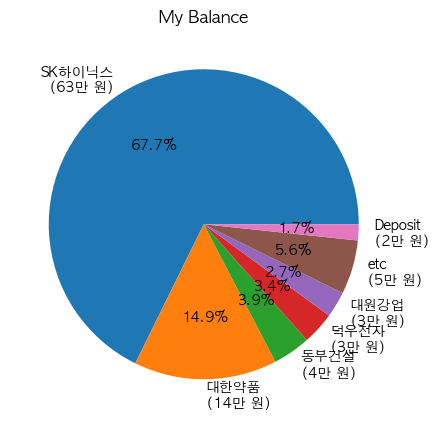

-- Trand_of_Users -- (1)
---- Total Price by Category about all users


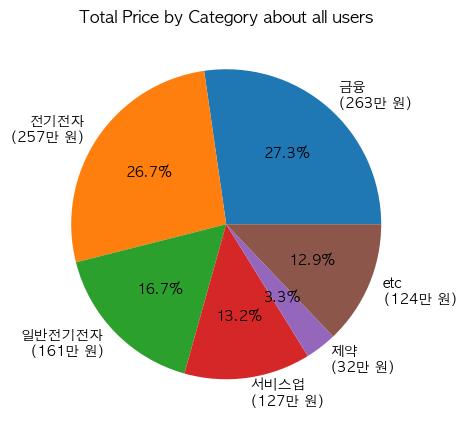

-----------------------------------------------------------------
-- Trand_of_Users -- (2)
---- Total Price by StockName about all users


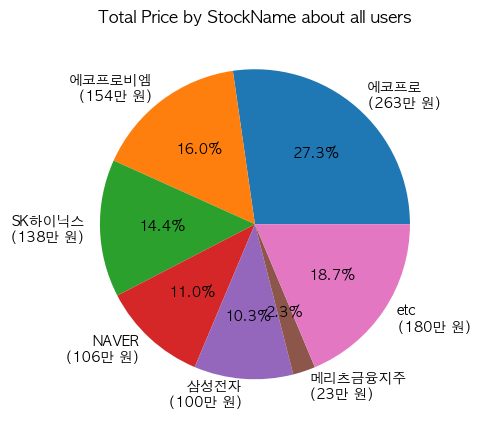

-- Compare stock accounts with other users with the same favorite category -- (1)
    I am : jiho264
    My FavCategory is :  전기전자
-----------------------------------------------------------------
-- Compare stock accounts with other users with the same favorite category -- (2)
    I did not bought : 
  StockName   Price Category
0      대한전선   11960     전기전자
1      삼성전자   71200     전기전자
2      삼성전자   71200     전기전자
3      삼성전기  145300     전기전자
-- Compare stock accounts with NPS Account -- (1)
---- NPS Account Top 12


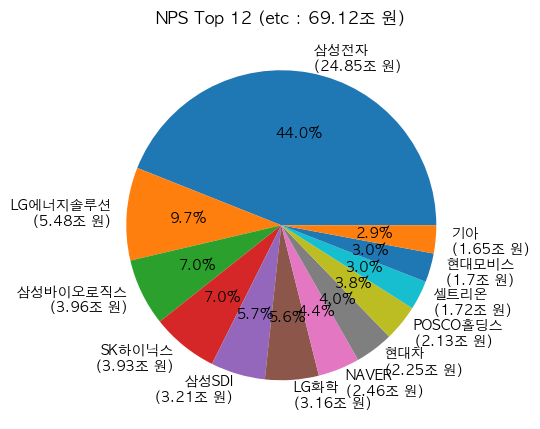

-----------------------------------------------------------------
-- Compare stock accounts with NPS Account -- (2)
---- Missing Stocks : 
['셀트리온', '삼성SDI', 'LG에너지솔루션', '삼성바이오로직스', 'NAVER', '현대차', '기아', '현대모비스', 'LG화학', 'POSCO홀딩스', '삼성전자']
-- Exchange Rate -- 
    지금은 환율 조회 서비스 점검 시간입니다.
Thanks for using this program!


In [104]:
USER_ID = "jiho264"
USER_PW = "admin"
Runner(conn, USER_ID, USER_PW).run()